

![Alt text](descargar.jpg)

## Intro

Proyecto de Analisis de datos NBA usando una api para la descarga de varios csv ("Lideres de la liga" y Lideres historicos ordenado). 

El primer csv es un ejercicio sencillo de llamada a la api mientras que el segundo es algo mas complejo al ser varios dataframes en el que uso concat.

### Hipotesis de Lideres de la liga

¿Son los Pivots los mejores en % de tiro?
¿Son los Bases los mejores en asistencias?
¿Son los Aleros los mejores en % de 3 puntos?
¿Son los Pivots los mejores en rebotes?

### Hipotesis de Lideres historicos

¿Es Lebron James el mejor jugador en mas categorias?

¿Hay mas jugadores activos en la NBA en el top 100 historico que retirados?

## Hipotesis extra

¿Hay una correlacion entre los tiros de Lebron James y el numero de personas que se dedican a cambiar ruedas en Carolina del norte?

## Paso 1: Importar las bibliotecas necesarias

Necesitamos instalar las bibliotecas Pandas, NumPy, Matplotlib, SciPy y Seaborn en python para continuar.

In [89]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats

Para poder validar las hipotesis necesitaremos hacer diversas llamadas a la api de la nba

Tambien necesitaremos importar Json para poder leer los datos recibidos desde la api.

In [90]:
from nba_api.stats.static import players
from nba_api.stats.endpoints import playercareerstats
from nba_api.stats.endpoints import LeagueLeaders
from nba_api.stats.endpoints.alltimeleadersgrids import AllTimeLeadersGrids

import json

## Creación de los dataframes ("Lideres de la liga" y Lideres historicos ordenado")

Para validar nuestras hipotesis necesitamos crear 2 dataframes Lideres de la liga (para datos estadisticos por temporada en la NBA) y Lideres historicos ordenado(para los mejores jugadores de la historia de la NBA)

Para ello usamos la informacion que nos proporciona el Github NBA Api (https://github.com/swar/nba_api)

El primer dataframe lo logramos de manera sencilla marcando los parametros que buscamos y lo convertimos a csv

In [91]:

league_leaders = LeagueLeaders(
    league_id = '00', # nba 00, g_league 20, wnba 10
    season = '2024-25', # Se puede cambiar dependiendo del año.
    per_mode48 = 'Totals', # "Totals", "Per48", "PerGame"
    )
df_league_leaders = league_leaders.get_data_frames()[0]
df_league_leaders.to_csv("Lideres de la liga.csv", index=False, encoding="utf-8-sig")
print("✅ Data importada a Lideres de la liga.csv") 

✅ Data importada a Lideres de la liga.csv


El dataframe de Lideres historicos es mas complejo ya que consta de varios dataframes.

Recogemos toda la informacion de la api bajo "data_frames y creamos una lista vacia.

In [92]:
data = AllTimeLeadersGrids()
data_frames = data.get_data_frames()

lista = []

A continuacion elaboramos un bucle for para que se recorran los dataframes y seleccione las columnas estadisticas y el ranking.

Despues buscamos que se junten en un mismo dataframe que llamamos "df_final" y lo convertimos a csv

In [93]:
for df in data_frames:
    stat_cols = [c for c in df.columns if c not in ['PLAYER_ID', 'PLAYER_NAME', 'IS_ACTIVE_FLAG'] and not c.endswith('_RANK')]
    rank_cols = [c for c in df.columns if c.endswith('_RANK')]
    
    if not stat_cols or not rank_cols:
        continue  
    
    stat = stat_cols[0]
    rank_col = rank_cols[0]
    
    ordenado = df[['PLAYER_ID', 'PLAYER_NAME', stat, rank_col, 'IS_ACTIVE_FLAG']].copy()
    ordenado.columns = ['PLAYER_ID', 'PLAYER_NAME', 'VALUE', 'RANK', 'IS_ACTIVE_FLAG']
    ordenado['CATEGORY'] = stat
    lista.append(ordenado)

df_final = pd.concat(lista, ignore_index=True)


df_final.to_csv("Lideres_historicos_ordenado.csv", index=False, encoding="utf-8-sig")
print("✅ Archivo 'Lideres_historicos_ordenado.csv' creado correctamente.")

✅ Archivo 'Lideres_historicos_ordenado.csv' creado correctamente.


## Paso 2: Lectura del conjunto de datos de Lideres de la liga

Leamos el conjunto de datos usando pandas.

In [94]:
lideres = pd.read_csv("Lideres de la liga.csv"),

lideres

(     PLAYER_ID  RANK                   PLAYER     TEAM_ID TEAM  GP   MIN  FGM  \
 0      1628983     1  Shai Gilgeous-Alexander  1610612760  OKC  76  2598  860   
 1      1630162     2          Anthony Edwards  1610612750  MIN  79  2871  721   
 2       203999     3             Nikola Jokić  1610612743  DEN  70  2571  786   
 3       203507     4    Giannis Antetokounmpo  1610612749  MIL  67  2289  793   
 4      1628369     5             Jayson Tatum  1610612738  BOS  72  2624  662   
 ..         ...   ...                      ...         ...  ...  ..   ...  ...   
 564    1630644   561              Mac McClung  1610612753  ORL   2    10    0   
 565    1642434   561              Riley Minix  1610612759  SAS   1     7    0   
 566    1629056   561            Terence Davis  1610612758  SAC   1     8    0   
 567    1630678   561             Terry Taylor  1610612758  SAC   3     6    0   
 568    1642389   561              Zyon Pullin  1610612763  MEM   3     3    0   
 
       FGA  FG

## Paso 3 Analisis de los datos

### Comenzamos con aislar los datos de los mejores jugadores por % de tiro

Para ello convertimos los datos para que solo se escojan los 200 valores primeros. De esta manera evitamos que jugadores con un tiro anotado durante la temporada puedan quedar como los mejores en % de tiro. 

Despues aplicamos la mascara para que nos fijemos en los jugadores y su % de tiro haciendo que se vea de manera descendiente.

In [95]:
lideres_df = lideres[0] 
lideres_df = lideres_df.head(200) 

lideres_fg_pct = lideres_df[["PLAYER", "FG_PCT"]]
lideres_fg_pct = lideres_fg_pct.sort_values(by="FG_PCT", ascending=False)
top10_fg_pct = lideres_fg_pct.head(10)

print(top10_fg_pct)


                    PLAYER  FG_PCT
71           Jarrett Allen   0.706
153         Daniel Gafford   0.702
95             Jalen Duren   0.692
106            Rudy Gobert   0.669
175         Walker Kessler   0.663
40             Ivica Zubac   0.628
116           Jakob Poeltl   0.627
168          Mark Williams   0.604
3    Giannis Antetokounmpo   0.601
41        Domantas Sabonis   0.590


Para poder visualizar mejor los datos realizamos un grafico de barras para ver las diferencias entre jugadores.

En este caso nuestra hipotesis se cumple al ver que todos son pivots o interiores.

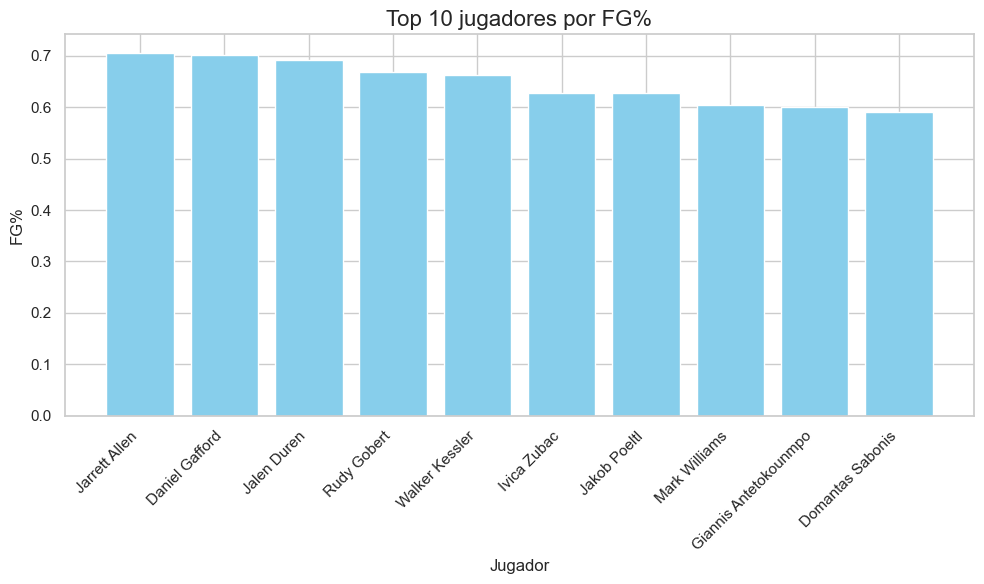

In [96]:
top10_fg_pct = lideres_fg_pct.head(10)

plt.figure(figsize=(10, 6))
plt.bar(top10_fg_pct["PLAYER"], top10_fg_pct["FG_PCT"], color="skyblue")
plt.title("Top 10 jugadores por FG%", fontsize=16)
plt.xlabel("Jugador", fontsize=12)
plt.ylabel("FG%", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

### Continuamos con la siguiente hipotesis: ¿Son los Aleros los mejores en % de tiro de 3?

Para ello realizamos el mismo ejercicio previo pero centrandonos en el % de tiro de 3.

In [97]:
lideres_df = lideres[0] 
lideres_df = lideres_df.head(200) 

lideres_fg3_pct = lideres_df[["PLAYER", "FG3_PCT"]]
lideres_fg3_pct = lideres_fg3_pct.sort_values(by="FG3_PCT", ascending=False)
top10_fg3_pct = lideres_fg3_pct.head(10)

print(top10_fg3_pct)


               PLAYER  FG3_PCT
11        Zach LaVine    0.446
103         Ty Jerome    0.439
173    Taurean Prince    0.439
138      Aaron Gordon    0.436
82    Harrison Barnes    0.433
199      Luke Kennard    0.433
170        Keon Ellis    0.433
18       Kevin Durant    0.430
162     Grayson Allen    0.426
131  Brice Sensabaugh    0.422


Aplicamos el mismo grafico y vemos que hay 3 jugadores que no encajarian dentro de los aleros.

Utilizamos un bucle for para resaltar dichos jugadores en la presentacion para reflejar que la hipotesis se cumple aunque es menos plausible que nuestra hipotesis previa.

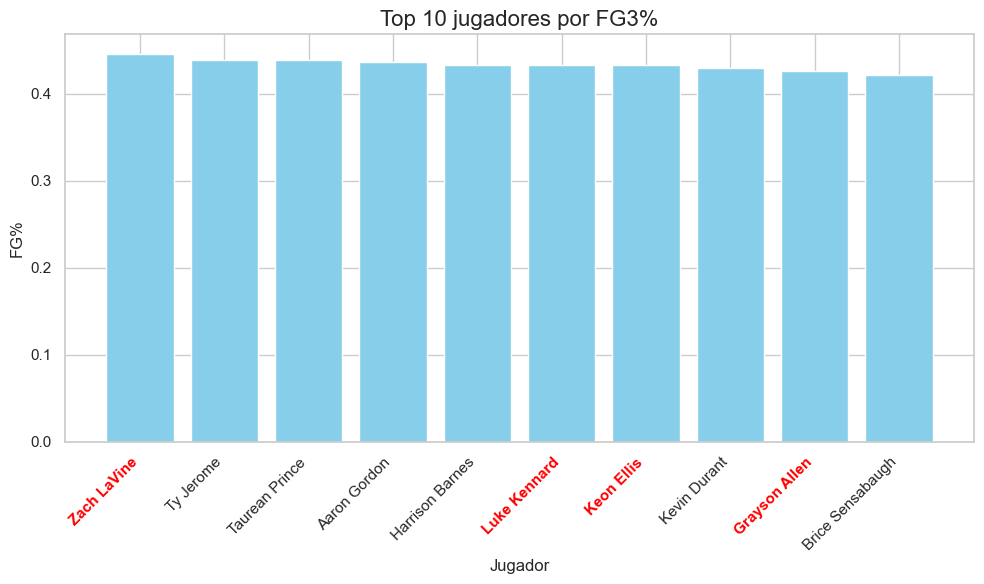

In [98]:
top10_fg3_pct = lideres_fg3_pct.head(10)

plt.figure(figsize=(10, 6))
plt.bar(top10_fg3_pct["PLAYER"], top10_fg3_pct["FG3_PCT"], color="skyblue")
plt.title("Top 10 jugadores por FG3%", fontsize=16)
plt.xlabel("Jugador", fontsize=12)
plt.ylabel("FG%", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()


for label in plt.gca().get_xticklabels():
    if "Zach LaVine" in label.get_text():
        label.set_color("red")
        label.set_fontweight("bold")
    elif "Luke Kennard" in label.get_text():
        label.set_color("red")
        label.set_fontweight("bold")
    elif "Keon Ellis" in label.get_text():
        label.set_color("red")
        label.set_fontweight("bold")
    elif "Grayson Allen" in label.get_text():
        label.set_color("red")
        label.set_fontweight("bold")
plt.show()

### Continuamos con la siguiente hipotesis: ¿Son los Bases los mejores en asistencias?

Para ello realizamos el mismo ejercicio previo pero centrandonos en el maximo de asistencias realizadas.

En este caso, al no ser un porcentaje, no necesitamos filtrar por los 200 mejores registros.

In [99]:
lideres_ast = lideres_df[["PLAYER", "AST"]]
lideres_ast = lideres_ast.sort_values(ascending=False, by="AST")
lideres_ast[:10]


,PLAYER,AST
6,Trae Young,880
2,Nikola Jokić,716
9,James Harden,687
37,Tyrese Haliburton,673
8,Cade Cunningham,638
146,Chris Paul,605
15,LeBron James,575
5,Devin Booker,529
21,Darius Garland,506
81,Josh Giddey,503


A continuacion realizamos la visualizacion e identificamos que hay unicamente un jugador que no coincide con la posicion de Base.

Utilizamos un bucle for para resaltarlo.

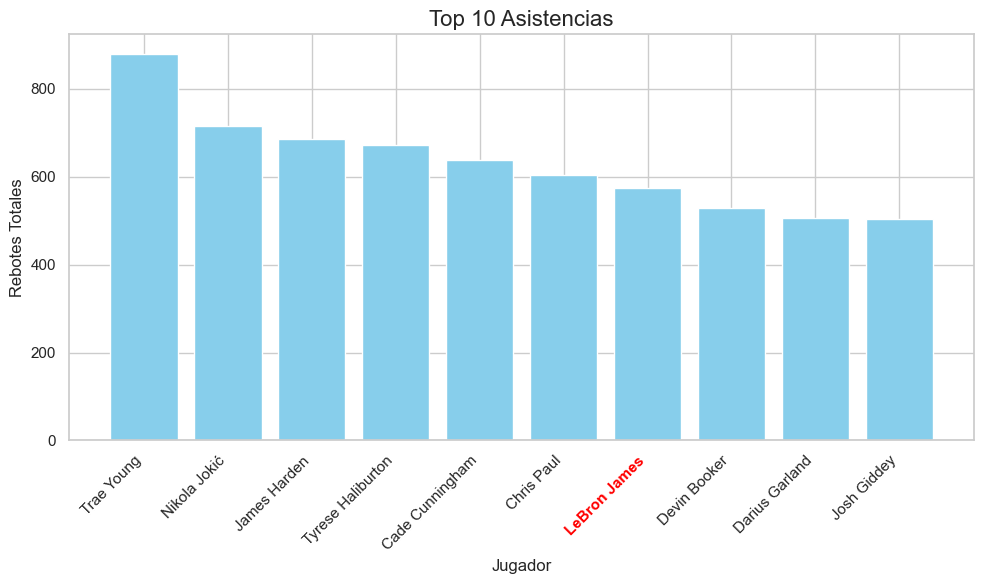

In [100]:
top10_ast = lideres_ast.head(10)

plt.figure(figsize=(10, 6))
plt.bar(top10_ast["PLAYER"], top10_ast["AST"], color="skyblue")
plt.title("Top 10 Asistencias", fontsize=16)
plt.xlabel("Jugador", fontsize=12)
plt.ylabel("Rebotes Totales", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()


for label in plt.gca().get_xticklabels():
    if "Nikola Jokic" in label.get_text():
        label.set_color("red")
        label.set_fontweight("bold")
    elif "LeBron James" in label.get_text():
        label.set_color("red")
        label.set_fontweight("bold")
plt.show()

### Finalmente ultima hipotesis: ¿Son los Pivots los mejores en rebotes?

Para ello realizamos el mismo ejercicio previo pero centrandonos en el maximo de rebotes capturados.

En este caso, al no ser un porcentaje, no necesitamos filtrar por los 200 mejores registros.

In [101]:
lideres_reb = lideres_df[["PLAYER", "REB"]]
lideres_reb = lideres_reb.sort_values(ascending=False, by="REB")
lideres_reb[:10]

,PLAYER,REB
40,Ivica Zubac,1010
41,Domantas Sabonis,972
10,Karl-Anthony Towns,920
2,Nikola Jokić,892
95,Jalen Duren,807
71,Jarrett Allen,798
3,Giannis Antetokounmpo,798
26,Alperen Sengun,786
106,Rudy Gobert,785
31,Bam Adebayo,749


A continuacion realizamos la visualizacion e identificamos que todos los jugadores que tenemos en la lista son pivots.

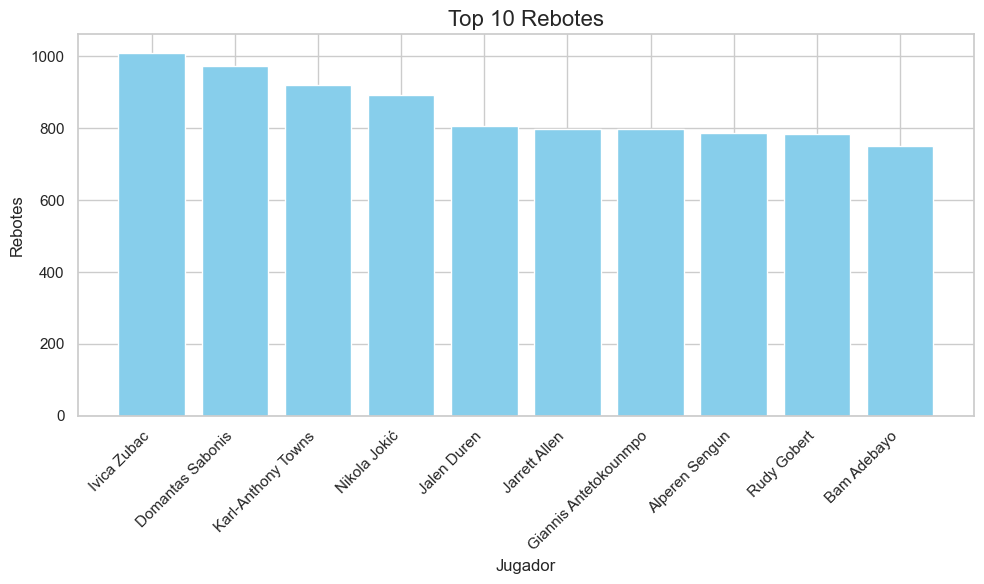

In [102]:
top10_reb = lideres_reb.head(10)

# Crear gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(top10_reb["PLAYER"], top10_reb["REB"], color="skyblue")
plt.title("Top 10 Rebotes", fontsize=16)
plt.xlabel("Jugador", fontsize=12)
plt.ylabel("Rebotes", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


### 5 Hipotesis: ¿Es Lebron James el mejor jugador en mas categorias?

Comenzamos importantdo datos de la api de la nba, especificamente de players y playercarrerstats.

In [103]:
from nba_api.stats.static import players
from nba_api.stats.endpoints import playercareerstats

Continuamos buscando el ID de Lebron James para poder conseguir sus datos y ademas buscamos sus estadisticas de carrera, averages y puntos por temporada

   PLAYER_ID SEASON_ID LEAGUE_ID     TEAM_ID TEAM_ABBREVIATION  PLAYER_AGE  \
0       2544   2003-04        00  1610612739               CLE        19.0   
1       2544   2004-05        00  1610612739               CLE        20.0   
2       2544   2005-06        00  1610612739               CLE        21.0   
3       2544   2006-07        00  1610612739               CLE        22.0   
4       2544   2007-08        00  1610612739               CLE        23.0   

   GP  GS   MIN  FGM  ...  FT_PCT  OREB  DREB  REB  AST  STL  BLK  TOV   PF  \
0  79  79  3120  622  ...   0.754    99   333  432  465  130   58  273  149   
1  80  80  3388  795  ...   0.750   111   477  588  577  177   52  262  146   
2  79  79  3361  875  ...   0.738    75   481  556  521  123   66  260  181   
3  78  78  3190  772  ...   0.698    83   443  526  470  125   55  250  171   
4  75  74  3027  794  ...   0.712   133   459  592  539  138   81  255  165   

    PTS  
0  1654  
1  2175  
2  2478  
3  2132  
4  225

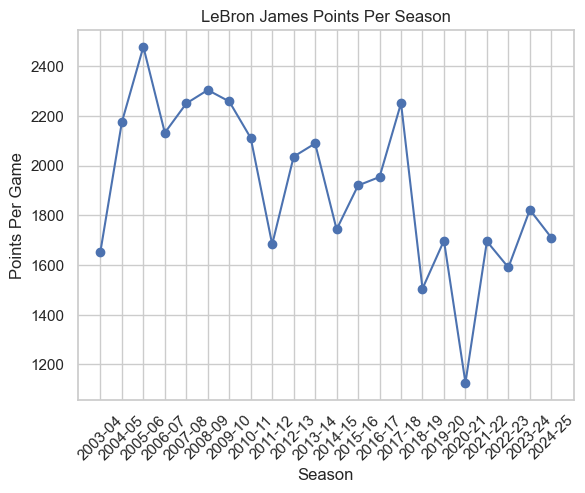

In [104]:
# LeBron James' player ID
lebron = [player for player in players.get_players() if player['full_name'] == "LeBron James"][0]
lebron_id = lebron['id']

# estadisticas de carrera
career_stats = playercareerstats.PlayerCareerStats(player_id=lebron_id)
df = career_stats.get_data_frames()[0]
print(df.head())


# Averages de Lebron
career_averages = df[df['SEASON_ID'] == 'Career'][['PTS', 'REB', 'AST']]
print("LeBron's Career Averages:")
print(career_averages)

# Puntos de Lebron por temporada
df_season = df[df['SEASON_ID'] != 'Career']
plt.plot(df_season['SEASON_ID'], df_season['PTS'], marker='o')
plt.title("LeBron James Points Per Season")
plt.xlabel("Season")
plt.ylabel("Points Per Game")
plt.xticks(rotation=45)
plt.show()




Una vez logrados los datos buscamos realizar los graficos para poder comparar a Lebron con otros jugadores en diversas caracteristicas.

Comenzamos con los puntos

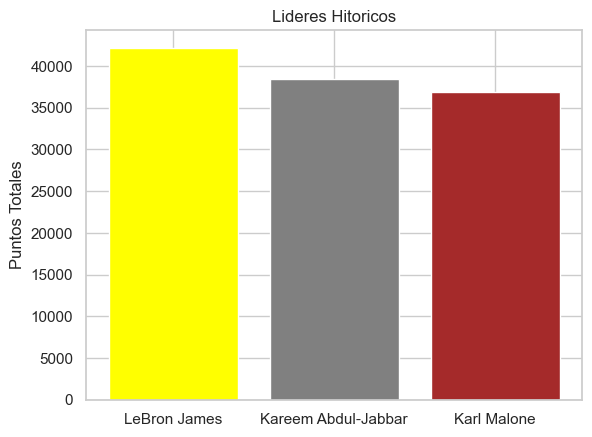

In [105]:
# Lebron VS otros jugadores
all_time_points = {'LeBron James': 42184, 'Kareem Abdul-Jabbar': 38387, 'Karl Malone': 36928}
players = list(all_time_points.keys())
points = list(all_time_points.values())

plt.bar(players, points, color=['yellow', 'grey', 'brown'])
plt.title("Lideres Hitoricos")
plt.ylabel("Puntos Totales")
plt.show()

Seguimos con las asistencias, en este caso no se encuentra en el top 3 asique decidimos añadirle.

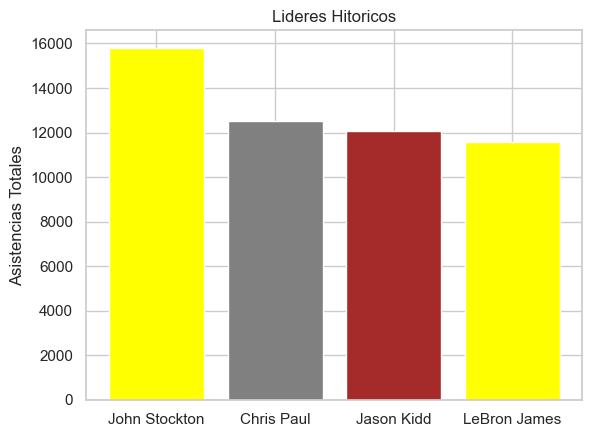

In [106]:
# Lebron VS otros jugadores
all_time_asis = {'John Stockton': 15806, 'Chris Paul': 12528, 'Jason Kidd': 12091 ,'LeBron James': 11584}
players = list(all_time_asis.keys())
points = list(all_time_asis.values())

plt.bar(players, points, color=['yellow', 'grey', 'brown'])
plt.title("Lideres Hitoricos")
plt.ylabel("Asistencias Totales")
plt.show()

Finalizamos con los robos

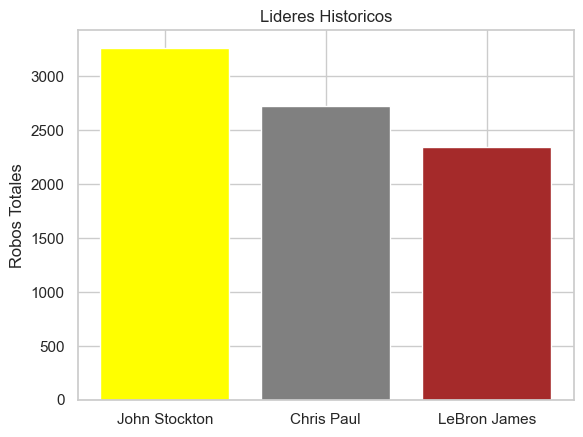

In [107]:
# Lebron VS otros jugadores
all_time_stl = {'John Stockton': 3265, 'Chris Paul': 2726,'LeBron James': 2345}
players = list(all_time_stl.keys())
points = list(all_time_stl.values())

plt.bar(players, points, color=['yellow', 'grey', 'brown'])
plt.title("Lideres Historicos")
plt.ylabel("Robos Totales")
plt.show()

Podemos ver que LeBron James esta en varias categorias dentro de los mejores de la liga, ¿pero estara en todas?

Para validarlo creamos una mascara con su nombre y buscamos ver si esta dentro de ese top10 de lideres historicos.

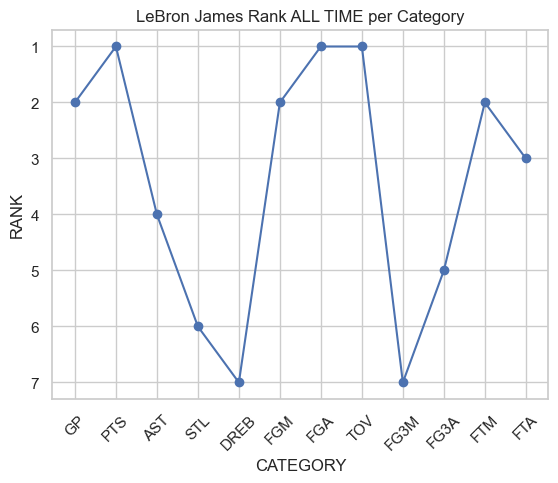

In [108]:
historicos = pd.read_csv("Lideres_historicos_ordenado.csv")

lebron_historico = historicos[historicos["PLAYER_NAME"] == "LeBron James"]

lebron_historico[["PLAYER_NAME", "RANK", "CATEGORY"]]

plt.plot(lebron_historico['CATEGORY'], lebron_historico['RANK'], marker='o')
plt.title("LeBron James Rank ALL TIME per Category")
plt.xlabel("CATEGORY")
plt.ylabel("RANK")
plt.xticks(rotation=45)

plt.gca().invert_yaxis()
plt.show()


Para dar algo mas de calidad al grafico realizamos otra prueba pero usand Seaborn.

C:\Users\ikerh\AppData\Local\Temp\ipykernel_16828\1979986141.py:21: UserWarning: Glyph 127936 (\N{BASKETBALL AND HOOP}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\ikerh\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127936 (\N{BASKETBALL AND HOOP}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


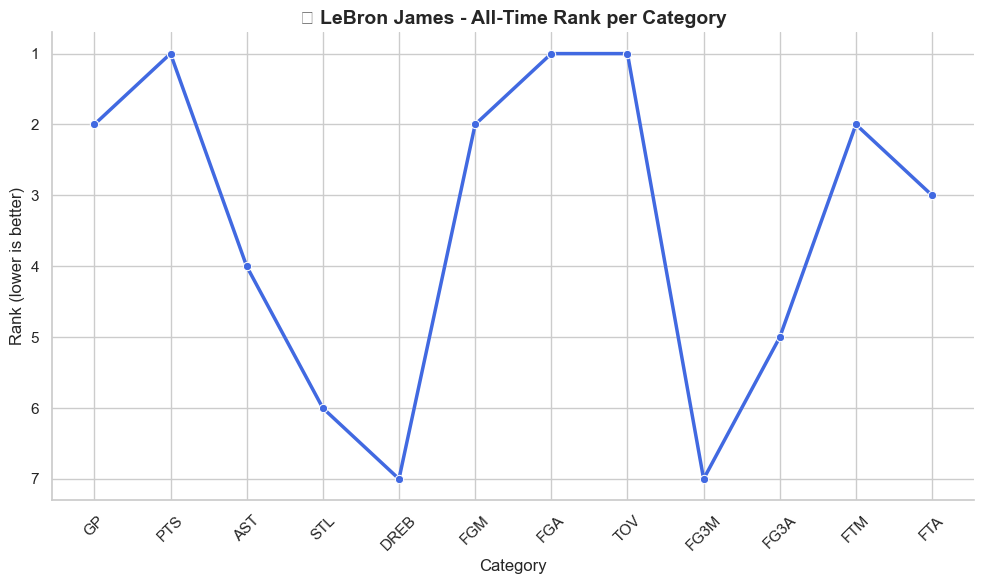

In [109]:
# Estilo general
sns.set_theme(style="whitegrid")

plt.figure(figsize=(10,6))
sns.lineplot(
    data=lebron_historico,
    x='CATEGORY',
    y='RANK',
    marker='o',
    linewidth=2.5,
    color='royalblue'
)

plt.title("🏀 LeBron James - All-Time Rank per Category", fontsize=14, fontweight='bold')
plt.xlabel("Category", fontsize=12)
plt.ylabel("Rank (lower is better)", fontsize=12)
plt.xticks(rotation=45)
plt.gca().invert_yaxis()  # Mostrar mejores posiciones arriba

sns.despine()
plt.tight_layout()
plt.show()


## Hipotesis ¿Hay mas jugadores activos en el top historico de la liga o no?

Para analizar esta hipotesis utilizamos el dataframe generado previamente.

In [110]:
historicos = pd.read_csv("Lideres_historicos_ordenado.csv")

Para poder analizar mejor el dataframe buscamos ver cuantos registros hay por Categoria. Podemos ver que nos sale el Top 10 de los jugaores en la historia de la NBA por cada categoria.

In [111]:
historicos["CATEGORY"].value_counts()

CATEGORY
GP         10
PTS        10
AST        10
STL        10
OREB       10
DREB       10
REB        10
BLK        10
FGM        10
FGA        10
FG_PCT     10
TOV        10
FG3M       10
FG3A       10
FG3_PCT    10
PF         10
FTM        10
FTA        10
FT_PCT     10
Name: count, dtype: int64

Para poder revisar mejor el dataframe convertimos la columna Rank en el index.

In [112]:
historicos.set_index("RANK")

,PLAYER_ID,PLAYER_NAME,VALUE,IS_ACTIVE_FLAG,CATEGORY
RANK,,,,,
1,305,Robert Parish,1611.000,N,GP
2,2544,LeBron James,1562.000,Y,GP
3,76003,Kareem Abdul-Jabbar,1560.000,N,GP
4,1713,Vince Carter,1541.000,N,GP
5,1717,Dirk Nowitzki,1522.000,N,GP
...,...,...,...,...,...
6,978,Peja Stojakovic,0.895,N,FT_PCT
7,1497,Chauncey Billups,0.894,N,FT_PCT
7,951,Ray Allen,0.894,N,FT_PCT


A continuacion creamos una mascara que nos permita detectar que jugadores estan activos actualmente y la aplicamos al dataframe.

Al aplicar ".value_counts()" podemos ver que no se cumple la hipotesis pero para hacerlo mas claro haremos un grafico a continuacion.

In [113]:
historicos[historicos["IS_ACTIVE_FLAG"] == "Y"].value_counts

historicos_activos = historicos[historicos["IS_ACTIVE_FLAG"] == "Y"]

status_counts = historicos["IS_ACTIVE_FLAG"].value_counts()

status_counts

IS_ACTIVE_FLAG
N    147
Y     43
Name: count, dtype: int64

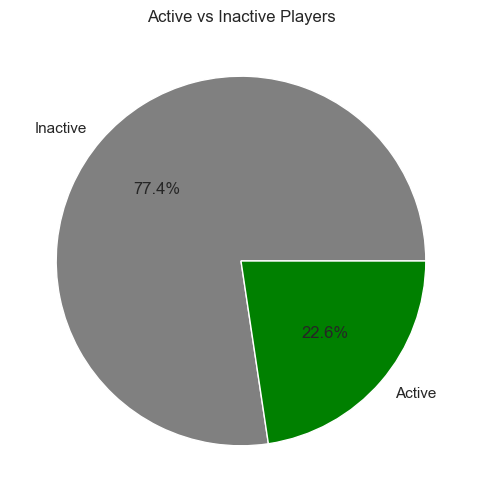

In [114]:
plt.figure(figsize=(6, 6))
plt.pie(status_counts, labels=["Inactive", "Active"], autopct='%1.1f%%', colors=["grey", "green"])
plt.title("Active vs Inactive Players")
plt.show()

Queda demostrado que no hay mas jugadores activos que inactivos en el top10 por categorias actualmente.

In [115]:
historicos_gp = historicos[historicos["CATEGORY"] == "GP"]

historicos_pts = historicos[historicos["CATEGORY"] == "PTS"]

historicos_ast = historicos[historicos["CATEGORY"] == "AST"]

historicos_stl = historicos[historicos["CATEGORY"] == "STL"]

historicos_orb = historicos[historicos["CATEGORY"] == "ORB"]

historicos_drb = historicos[historicos["CATEGORY"] == "DRB"]

historicos_reb = historicos[historicos["CATEGORY"] == "REB"]

historicos_blk = historicos[historicos["CATEGORY"] == "BLK"]

historicos_fgm = historicos[historicos["CATEGORY"] == "FGM"]

historicos_fga = historicos[historicos["CATEGORY"] == "FGA"]

historicos_fg_pct = historicos[historicos["CATEGORY"] == "FG_PCT"]

historicos_tov = historicos[historicos["CATEGORY"] == "TOV"]

historicos_fg3m = historicos[historicos["CATEGORY"] == "FG3M"]

historicos_fg3a= historicos[historicos["CATEGORY"] == "FG3A"]

historicos_pf= historicos[historicos["CATEGORY"] == "PF"]

historicos_ftm = historicos[historicos["CATEGORY"] == "FTM"]

historicos_fta = historicos[historicos["CATEGORY"] == "FTA"]

historicos_ft_pct= historicos[historicos["CATEGORY"] == "FT_PCT"]

In [116]:
historicos_fta

,PLAYER_ID,PLAYER_NAME,VALUE,RANK,IS_ACTIVE_FLAG,CATEGORY
170,252,Karl Malone,13188.0,1,N,FTA
171,76375,Wilt Chamberlain,11862.0,2,N,FTA
172,2544,LeBron James,11735.0,3,Y,FTA
173,406,Shaquille O'Neal,11252.0,4,N,FTA
174,77449,Moses Malone,11090.0,5,N,FTA
175,977,Kobe Bryant,10011.0,6,N,FTA
176,201935,James Harden,9533.0,7,Y,FTA
177,2730,Dwight Howard,9455.0,8,N,FTA
178,76003,Kareem Abdul-Jabbar,9304.0,9,N,FTA
179,600015,Oscar Robertson,9185.0,10,N,FTA


## Hipotesis extra: ¿Influyo los tiros anotados de Lebron James en en numero de mecánicos que cambian y reparan ruedas en Carolina del Norte?

Para comenzar recogemos la informacion de 2 fuentes: "Fuente: Basketball-Reference & Bureau of Labor Statistics" y creamos una funcion que nos ayudara a calcular la correlacion entre las dos fuentes de datos. 



In [117]:
def calculate_correlation(array1, array2):

    # Correlacion de Pearson y p-value
    correlation, p_value = stats.pearsonr(array1, array2)

    # Calcular el R-squared como el cuadrado del coeficiente de correlacion
    r_squared = correlation**2

    return correlation, r_squared, p_value

A continuacion reflejamos en 2 arrays los datos referentes a Lebron o al numero de mecanicos y genereamos el data frame para poder ejecutar la funcion de correlacion. Generamos un print para visualizar el resultado.

In [118]:
array_1 = np.array([622,795,875,772,794,789,768,758,621,765,767,624,737,736,857,558,643,422,640,609,])
array_2 = np.array([3180,3910,4140,4160,3670,3490,3140,2680,2690,2750,3060,2820,3300,3120,3730,2880,2680,2090,2590,2330,])
array_1_name = "Numero de tiros de Lebron James"
array_2_name = "Numero de mecánicos que cambian y reparan ruedas en Carolina del Norte"
correlation_df = pd.DataFrame({'Numero de tiros de Lebron James': array_1, 'Numero de mecánicos que cambian y reparan ruedas en Carolina del norte': array_2})
print(f"Calcular la correlacion entre {array_1_name} y {array_2_name}...")

Calcular la correlacion entre Numero de tiros de Lebron James y Numero de mecánicos que cambian y reparan ruedas en Carolina del Norte...


Ademas buscamos calcular el "r cuadrada" y el "p_value" para añadir mas valores de analisis que nos ayuden a validar o no nuestra hipotesis.

In [119]:
correlation, r_squared, p_value = calculate_correlation(array_1, array_2)

print("Coeficiente de correlacion:", correlation)
print("R cuadrada:", r_squared)
print("P-value:", p_value)

Coeficiente de correlacion: 0.7849835098708715
R cuadrada: 0.6161991107691926
P-value: 4.146486594974442e-05


Finalmente, añadimos el rango de años del que disponemos datos y comenzamos a elaborar una visualizacion de tipo plot para ver si ambos datos tienen relacion.

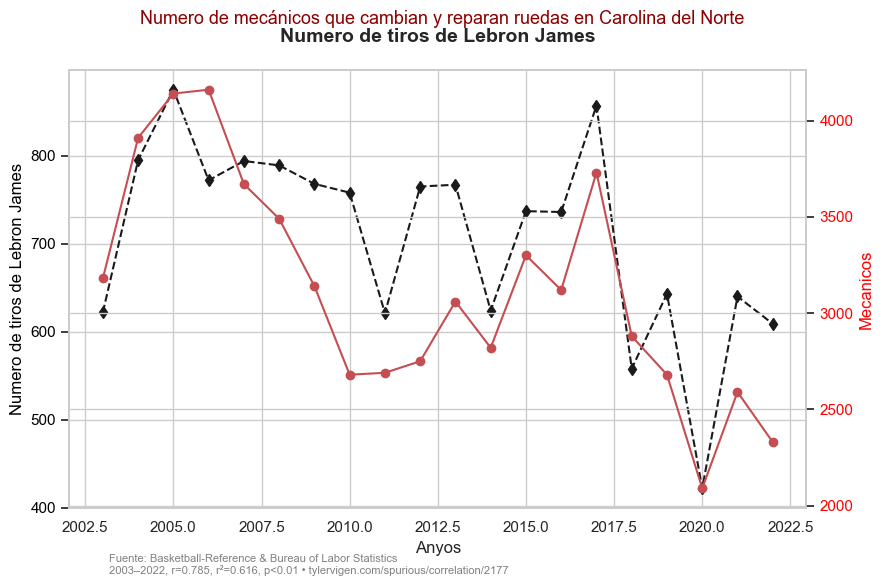

In [122]:
years = np.arange(2003, 2023)

fig, ax1 = plt.subplots(figsize=(9, 6))

# Lebron
ax1.plot(years, array_1, 'k--', marker='d', label="Numero de tiros de Lebron James")
ax1.set_xlabel('Anyos')
ax1.set_ylabel('Numero de tiros de Lebron James', color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Mecanicos
ax2 = ax1.twinx()
ax2.plot(years, array_2, 'r-', marker='o', label="Numero de mecánicos que cambian y reparan ruedas en Carolina del norte")
ax2.set_ylabel('Mecanicos', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Titlulos
plt.title("Numero de tiros de Lebron James", fontsize=14, fontweight='bold', pad=20)
plt.suptitle("Numero de mecánicos que cambian y reparan ruedas en Carolina del Norte", 
             fontsize=13, color='darkred', y=0.94)

# Anotaciones
plt.figtext(0.13, 0.02, 
            "Fuente: Basketball-Reference & Bureau of Labor Statistics",
            fontsize=8, color='gray')

plt.figtext(0.13, 0.00, 
            "2003–2022, r=0.785, r²=0.616, p<0.01 • tylervigen.com/spurious/correlation/2177",
            fontsize=8, color='gray')


fig.tight_layout()

plt.show()


Podemos observar que pueden tener relacion aunque este no es el objetivo final de nuestra hipotesis sino demostrar que muchos de los estudios que vemos a diario pueden tener sesgos o interferencias que pueden aplicar a los datos si no se realiza de manera correcta.

En este caso podemos inferir lo siguiente:

Dragado de datos: En lugar de comenzar con una hipótesis y probarla, abusé de los datos para ver qué correlaciones se sacudían. Es una forma peligrosa de realizar análisis, porque cualquier conjunto de datos suficientemente grande producirá correlaciones sólidas completamente al azar.

Falta de conexión causal: Probablemente no hay conexión directa entre estas variables. Esto se ve ampliado por el hecho de que utilicé "Años" como variable base. ¡Muchas cosas suceden en un año que no están relacionadas entre sí!

Observaciones no independientes: Para muchas variables, los años secuenciales no son independientes entre sí. Si una población de personas está continuamente haciendo algo todos los días, no hay razón para pensar que cambiarían repentinamente la forma en que lo están haciendo el 1 de enero. El cálculo del valor p no tiene esto en cuenta, por lo que matemáticamente parece menos probable de lo que realmente es.

Variable de confusión: 2020 es particularmente diferente de los otros años en este gráfico. Las variables de confusión (como las pandemias globales) harán que dos variables parezcan conectadas cuando, de hecho, una "tercera variable furtiva" está influyendo en ambas detrás de escena.
